# Tutorial 2: Exploring the Movielens dataset with Spark Dataframes and Spark SQL

In this session we will use the movielens dataset to introduce the essential features of the Spark DataFrame API and showcase its power. This tutorial also has important links to the Spark documentation and/or other relevant material.

# Prerequisites

## Install Spark Environment
Since we are not running on databricks, we will need to install Spark by ourselves, every time we run the session.  

In [36]:
!pip install pyspark


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [37]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at /var/folders/sm/lw2bbffs15g5l3r4ldd25hc00000gn/T/ipykernel_12410/2894928871.py:6 

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

## Optional step : Enabling Spark UI through secure tunnel

This step is useful if you want to look at Spark UI.
First, you need to create a free ngrok account : https://dashboard.ngrok.com/login.  
Then connect on the website and copy your AuthToken.

In [39]:
"""# this step downloads ngrok, configures your AuthToken, then starts the tunnel
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
#!./ngrok authtoken my_ngrok_auth_token_retrieved_from_website # <-------------- change this line !
get_ipython().system_raw('./ngrok http 4050 &')"""

"# this step downloads ngrok, configures your AuthToken, then starts the tunnel\n!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip\n!unzip ngrok-stable-linux-amd64.zip\n#!./ngrok authtoken my_ngrok_auth_token_retrieved_from_website # <-------------- change this line !\nget_ipython().system_raw('./ngrok http 4050 &')"

## Other imports

In [40]:
%matplotlib inline

import urllib
import urllib.request as req
import zipfile
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PySpark DataFrame
import pyspark.sql.functions as F




## Downloading and unzipping the data (run only once !)

In [41]:
"""url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist()"""

"url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'\nfilehandle, _ = urllib.request.urlretrieve(url)\nzip_file_object = zipfile.ZipFile(filehandle, 'r')\nzip_file_object.namelist()"

In [42]:
# zip_file_object.extractall()

In [43]:
!cd ml-20m ; ls

README.txt          links.csv           ratings.csv         tags.csv
genome-scores.csv   movies-sample.csv   ratings.parquet
genome-tags.csv     movies.csv          sampled_ratings.csv


## Spark DataFrames essentials


### Reading data

In [44]:
movies_path = "ml-20m/movies.csv"
ratings_path = "ml-20m/ratings.csv"

We read the csv files using [`spark.read`](https://spark.apache.org/docs/latest/sql-data-sources-load-save-functions.html)

In [45]:
movies_df = spark.read.options(header=True).csv(movies_path)
ratings_df = spark.read.options(header=True).csv(ratings_path).sample(0.01)

We cache the read dataframes to avoid reloading them in subsequent computation.

In [46]:
movies_df.cache()
ratings_df.cache()

23/12/19 15:46:58 WARN CacheManager: Asked to cache already cached data.


DataFrame[userId: string, movieId: string, rating: string, timestamp: string]

We then print a few rows from each dataframe.

In [47]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+


In [48]:
ratings_df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|   1278|   4.0|1094785986|
|     3|   1084|   5.0| 944918103|
|     7|    788|   3.0|1011208527|
|     7|   3334|   3.0|1011207570|
|     7|   3417|   5.0|1011206698|
+------+-------+------+----------+


### Manipulating data

In [49]:
movies_df.select("title").show(5)

+--------------------+
|               title|
+--------------------+
|    Toy Story (1995)|
|      Jumanji (1995)|
|Grumpier Old Men ...|
|Waiting to Exhale...|
|Father of the Bri...|
+--------------------+


In [50]:
ratings_df.filter("rating=5").show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     3|   1084|   5.0| 944918103|
|     7|   3417|   5.0|1011206698|
|    11|   7481|   5.0|1230788624|
|    11|   8810|   5.0|1230783579|
|    14|   6424|   5.0|1225310675|
+------+-------+------+----------+


In [51]:
ratings_df.groupby("userId").agg({"movieId": "count"}).show(5)

+------+--------------+
|userId|count(movieId)|
+------+--------------+
|   675|             4|
|   829|             7|
|  1090|             1|
|  1159|             2|
|  1436|             4|
+------+--------------+


In [52]:
ratings_df.withColumn("is_rating_high", ratings_df["rating"] >= 4).show(5)

+------+-------+------+----------+--------------+
|userId|movieId|rating| timestamp|is_rating_high|
+------+-------+------+----------+--------------+
|     1|   1278|   4.0|1094785986|          true|
|     3|   1084|   5.0| 944918103|          true|
|     7|    788|   3.0|1011208527|         false|
|     7|   3334|   3.0|1011207570|         false|
|     7|   3417|   5.0|1011206698|          true|
+------+-------+------+----------+--------------+


In [53]:
ratings_df.withColumn("is_rating_low", ratings_df.rating < 4).show(5)

+------+-------+------+----------+-------------+
|userId|movieId|rating| timestamp|is_rating_low|
+------+-------+------+----------+-------------+
|     1|   1278|   4.0|1094785986|        false|
|     3|   1084|   5.0| 944918103|        false|
|     7|    788|   3.0|1011208527|         true|
|     7|   3334|   3.0|1011207570|         true|
|     7|   3417|   5.0|1011206698|        false|
+------+-------+------+----------+-------------+


In [54]:
ratings_df.withColumnRenamed("rating", "note").show(5)

+------+-------+----+----------+
|userId|movieId|note| timestamp|
+------+-------+----+----------+
|     1|   1278| 4.0|1094785986|
|     3|   1084| 5.0| 944918103|
|     7|    788| 3.0|1011208527|
|     7|   3334| 3.0|1011207570|
|     7|   3417| 5.0|1011206698|
+------+-------+----+----------+


https://spark.apache.org/docs/2.3.0/api/python/pyspark.sql.html#module-pyspark.sql.functions

### Built-in transformations and aggregations

In [55]:
ratings_df.select(F.avg("rating"), F.min("rating"), F.max("rating")).show()

+-----------------+-----------+-----------+
|      avg(rating)|min(rating)|max(rating)|
+-----------------+-----------+-----------+
|3.522168166422831|        0.5|        5.0|
+-----------------+-----------+-----------+


### Joining Dataframes

In [56]:
ratings_df.join(movies_df, "movieId").show(5)

+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|   1278|     1|   4.0|1094785986|Young Frankenstei...|      Comedy|Fantasy|
|   1084|     3|   5.0| 944918103|Bonnie and Clyde ...|         Crime|Drama|
|    788|     7|   3.0|1011208527|Nutty Professor, ...|Comedy|Fantasy|Ro...|
|   3334|     7|   3.0|1011207570|    Key Largo (1948)|Crime|Drama|Film-...|
|   3417|     7|   5.0|1011206698|Crimson Pirate, T...|    Adventure|Comedy|
+-------+------+------+----------+--------------------+--------------------+


### User Defined functions (UDFs)

In [57]:
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType


def length(string: str):
    return len(string)


length_udf = udf(length, LongType())

In [58]:
movies_df.select(length_udf("title")).show(5)

+-------------+
|length(title)|
+-------------+
|           16|
|           14|
|           23|
|           24|
|           34|
+-------------+


In [59]:
@udf("string")
def length2(string: str):
    return len(string)

In [60]:
movies_df.select(length2("title")).show(5)

+--------------+
|length2(title)|
+--------------+
|            16|
|            14|
|            23|
|            24|
|            34|
+--------------+


In [61]:
title_lengths = movies_df.select(length2("title").alias("title_length"))

In [62]:
title_lengths.select(F.max("title_length")).show()

+-----------------+
|max(title_length)|
+-----------------+
|               99|
+-----------------+


In [63]:
title_lengths.select(F.min("title_length")).show()

+-----------------+
|min(title_length)|
+-----------------+
|               10|
+-----------------+


### Query plan inspection and caching

In [64]:
title_lengths.select(F.max("title_length")).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortAggregate(key=[], functions=[max(title_length#3046)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=1368]
      +- SortAggregate(key=[], functions=[partial_max(title_length#3046)])
         +- InMemoryTableScan [title_length#3046]
               +- InMemoryRelation [title_length#3046], StorageLevel(disk, memory, deserialized, 1 replicas)
                     +- AdaptiveSparkPlan isFinalPlan=false
                        +- Project [pythonUDF0#1638 AS title_length#1326]
                           +- BatchEvalPython [length2(title#18)#1325], [pythonUDF0#1638]
                              +- InMemoryTableScan [title#18]
                                    +- InMemoryRelation [movieId#17, title#18, genres#19], StorageLevel(disk, memory, deserialized, 1 replicas)
                                          +- FileScan csv [movieId#17,title#18,genres#19] Batched: false, DataFilters: [], Format: CSV, Location: InMem

In [65]:
title_lengths.select(F.min("title_length")).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortAggregate(key=[], functions=[min(title_length#3046)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=1382]
      +- SortAggregate(key=[], functions=[partial_min(title_length#3046)])
         +- InMemoryTableScan [title_length#3046]
               +- InMemoryRelation [title_length#3046], StorageLevel(disk, memory, deserialized, 1 replicas)
                     +- AdaptiveSparkPlan isFinalPlan=false
                        +- Project [pythonUDF0#1638 AS title_length#1326]
                           +- BatchEvalPython [length2(title#18)#1325], [pythonUDF0#1638]
                              +- InMemoryTableScan [title#18]
                                    +- InMemoryRelation [movieId#17, title#18, genres#19], StorageLevel(disk, memory, deserialized, 1 replicas)
                                          +- FileScan csv [movieId#17,title#18,genres#19] Batched: false, DataFilters: [], Format: CSV, Location: InMem

In [66]:
title_lengths.cache()
title_lengths.select(F.max("title_length")).show()

+-----------------+
|max(title_length)|
+-----------------+
|               99|
+-----------------+


23/12/19 15:47:34 WARN CacheManager: Asked to cache already cached data.


In [67]:
title_lengths.select(F.min("title_length")).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortAggregate(key=[], functions=[min(title_length#3046)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=1432]
      +- SortAggregate(key=[], functions=[partial_min(title_length#3046)])
         +- InMemoryTableScan [title_length#3046]
               +- InMemoryRelation [title_length#3046], StorageLevel(disk, memory, deserialized, 1 replicas)
                     +- AdaptiveSparkPlan isFinalPlan=false
                        +- Project [pythonUDF0#1638 AS title_length#1326]
                           +- BatchEvalPython [length2(title#18)#1325], [pythonUDF0#1638]
                              +- InMemoryTableScan [title#18]
                                    +- InMemoryRelation [movieId#17, title#18, genres#19], StorageLevel(disk, memory, deserialized, 1 replicas)
                                          +- FileScan csv [movieId#17,title#18,genres#19] Batched: false, DataFilters: [], Format: CSV, Location: InMem

### Writing csv

In [68]:
movies_df.sample(0.1).write.csv("ml-20m/movies-sample.csv")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/quyenlinhta/IASD/bigdata/ml-20m/movies-sample.csv already exists. Set mode as "overwrite" to overwrite the existing path.

In [69]:
movies_df.sample(0.1).write.mode("overwrite").csv("ml-20m/movies-sample.csv")

Make sure you have written on filesystem correctly.

In [70]:
!cd ml-20m ; ls

README.txt          links.csv           ratings.csv         tags.csv
genome-scores.csv   movies-sample.csv   ratings.parquet
genome-tags.csv     movies.csv          sampled_ratings.csv


In [71]:
import os

os.listdir("ml-20m")

['links.csv',
 'sampled_ratings.csv',
 'ratings.parquet',
 'movies-sample.csv',
 'tags.csv',
 'genome-tags.csv',
 'ratings.csv',
 'README.txt',
 'genome-scores.csv',
 'movies.csv']

This command writes a dataframe in parquet format :

In [72]:
ratings_parquet_path = "ml-20m/ratings.parquet"
spark.read.options(header=True).csv(ratings_path).write.parquet(ratings_parquet_path)

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/quyenlinhta/IASD/bigdata/ml-20m/ratings.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

# Questions

## Question 0: Compare processing time and amount of executors used, when reading from csv versus reading from parquet, for the following pipelines:
- count total amount of records
- count total amount of records for user 1
- distinct count of timestamps

**hint** `countDistinct` method can be used for third pipeline

In [73]:
def timeit(func):
    import time
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Execution time: {end - start}")
        return result

    return wrapper

In [74]:
import warnings

warnings.filterwarnings("ignore")

In [75]:
@timeit
def count_records(df):
    return df.count()


@timeit
def count_records_for_user(df, user_id):
    return df.filter(f"userId={user_id}").count()


@timeit
def count_distinct_timestamps(df):
    return df.select(F.countDistinct("timestamp")).show()


for_df = spark.read.options(header=True).csv(ratings_path)
for_parquet = spark.read.parquet(ratings_parquet_path)
print("Counting records for csv:", count_records(for_df))
print("Counting records for parquet:", count_records(for_parquet))

print("Counting records for user 1 for csv:", count_records_for_user(for_df, 1))
print("Counting records for user 1 for parquet:", count_records_for_user(for_parquet, 1))

print("Counting distinct timestamps for csv:")
count_distinct_timestamps(for_df)
print("Counting distinct timestamps for parquet:")
count_distinct_timestamps(for_parquet)

Execution time: 0.9606108665466309
Counting records for csv: 20000263
Execution time: 0.21493005752563477
Counting records for parquet: 20000263


Execution time: 3.397679328918457
Counting records for user 1 for csv: 175


Execution time: 0.9519250392913818
Counting records for user 1 for parquet: 175
Counting distinct timestamps for csv:


23/12/19 15:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:51 WARN RowBasedKeyValueBatch: Calling spill() on

+-------------------------+
|count(DISTINCT timestamp)|
+-------------------------+
|                 15351121|
+-------------------------+

Execution time: 9.734538078308105
Counting distinct timestamps for parquet:


23/12/19 15:47:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/19 15:47:59 WARN RowBasedKeyValueBatch: Calling spill() on

+-------------------------+
|count(DISTINCT timestamp)|
+-------------------------+
|                 15351121|
+-------------------------+

Execution time: 6.573633909225464


## Question 1: Compute the (average, max, min) rating per movie, and get the highest and lowest rated movies ?

**hint** Straightforward GroupBy then Aggregate

In [76]:
ratings_df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|   1278|   4.0|1094785986|
|     3|   1084|   5.0| 944918103|
|     7|    788|   3.0|1011208527|
|     7|   3334|   3.0|1011207570|
|     7|   3417|   5.0|1011206698|
+------+-------+------+----------+


In [77]:
def get_avg_max_min(df):
    return df.groupBy("movieId").agg(F.avg("rating"), F.max("rating"), F.min("rating")).show()

In [78]:
print("The highest and lowest average rated movies are:")
get_avg_max_min(ratings_df)

The highest and lowest average rated movies are:
+-------+------------------+-----------+-----------+
|movieId|       avg(rating)|max(rating)|min(rating)|
+-------+------------------+-----------+-----------+
|      1|3.8811320754716983|        5.0|        0.5|
|     10|3.4105263157894736|        5.0|        0.5|
|    100|3.3421052631578947|        5.0|        1.0|
|   1000|               3.5|        5.0|        2.0|
| 100032|               3.0|        3.0|        3.0|
| 100052|               0.5|        0.5|        0.5|
| 100072|               3.0|        3.0|        3.0|
| 100083|               2.5|        2.5|        2.5|
| 100108|2.8333333333333335|        3.5|        2.0|
| 100163|               3.0|        3.0|        3.0|
|   1002|               3.0|        3.0|        3.0|
| 100244|3.3333333333333335|        3.5|        3.0|
| 100253|               3.0|        3.0|        3.0|
|   1003|3.1666666666666665|        5.0|        2.0|
| 100302|               2.5|        2.5|        2.

In [105]:
question1 = ratings_df.groupBy("movieId").agg(F.avg("rating"), F.max("rating"), F.min("rating"))
max_rating = question1.agg(F.max("avg(rating)")).collect()[0][0]
question1.filter(F.col("avg(rating)") == max_rating).show(1)

+-------+-----------+-----------+-----------+
|movieId|avg(rating)|max(rating)|min(rating)|
+-------+-----------+-----------+-----------+
| 100509|        5.0|        5.0|        5.0|
+-------+-----------+-----------+-----------+


In [107]:
min_rating = question1.agg(F.min("avg(rating)")).collect()[0][0]
question1.filter(F.col("avg(rating)") == min_rating).show(1)

+-------+-----------+-----------+-----------+
|movieId|avg(rating)|max(rating)|min(rating)|
+-------+-----------+-----------+-----------+
| 100052|        0.5|        0.5|        0.5|
+-------+-----------+-----------+-----------+


In [87]:
ratings_df.groupBy("movieId").agg(F.avg("rating"), F.max("rating"), F.min("rating")).sort("avg(rating)").take(-1)

AnalysisException: [INVALID_LIMIT_LIKE_EXPRESSION.IS_NEGATIVE] The limit like expression "-1" is invalid. The limit expression must be equal to or greater than 0, but got -1.;
GlobalLimit -1
+- LocalLimit -1
   +- Sort [avg(rating)#4703 ASC NULLS FIRST], true
      +- Aggregate [movieId#1820], [movieId#1820, avg(cast(rating#1821 as double)) AS avg(rating)#4703, max(rating#1821) AS max(rating)#4704, min(rating#1821) AS min(rating)#4705]
         +- Sample 0.0, 0.01, false, 8901743572571516393
            +- Relation [userId#1819,movieId#1820,rating#1821,timestamp#1822] csv


## Question 2: Amongst movies that were rated by at least 20 users, what are the movies with highest and lowest rating standard deviation ?

**hint** How do you use a join to keep only a subset of movies ?

In [114]:
question2 = ratings_df.groupBy("movieId").agg(F.count("userId"), F.stddev("rating")).filter("count(userId)>=20")
min_std = question2.agg(F.min("stddev(rating)")).collect()[0][0]
max_std = question2.agg(F.max("stddev(rating)")).collect()[0][0]
question2.filter(F.col("stddev(rating)") == min_std).show(1)
question2.filter(F.col("stddev(rating)") == max_std).show(1)


+-------+-------------+-------------------+
|movieId|count(userId)|     stddev(rating)|
+-------+-------------+-------------------+
|   2922|           21|0.45512949491639976|
+-------+-------------+-------------------+
+-------+-------------+-----------------+
|movieId|count(userId)|   stddev(rating)|
+-------+-------------+-----------------+
|   1924|           24|1.485284094232383|
+-------+-------------+-----------------+


## Question 3: Compute the (average, max, min) rating per genre and get the highest and lowest rated genres, as well as the ones with the highest rating standard deviation ?

**hint** How can you extract the individual genres from the genres column ? How do you use a custom function to do this ?

In [115]:
def get_genre(df):
    return df.withColumn("genre", F.explode(F.split("genres", "\|"))).groupBy("genre").agg(F.avg("rating"),
                                                                                           F.max("rating"),
                                                                                           F.min("rating")).show()


print("The highest and lowest average rated genres are:")
get_genre(ratings_df)

The highest and lowest average rated genres are:


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `genres` cannot be resolved. Did you mean one of the following? [`userId`, `movieId`, `rating`, `timestamp`].;
'Project [userId#1819, movieId#1820, rating#1821, timestamp#1822, explode(split('genres, \|, -1)) AS genre#10681]
+- Sample 0.0, 0.01, false, 8901743572571516393
   +- Relation [userId#1819,movieId#1820,rating#1821,timestamp#1822] csv


In [125]:
question3 = ratings_df.join(other=movies_df,
                            on=["movieId"],
                            how="left")

#Genres with the lowest ratings
question3.groupBy("genres").agg(F.avg("rating"), F.max("rating"), F.min("rating"), F.stddev("rating")).sort(
    "avg(rating)").head(5)

[Row(genres='Adventure|Drama|Horror|Sci-Fi|Thriller', avg(rating)=0.5, max(rating)='0.5', min(rating)='0.5', stddev(rating)=None),
 Row(genres='Documentary|Fantasy', avg(rating)=0.5, max(rating)='0.5', min(rating)='0.5', stddev(rating)=None),
 Row(genres='Animation|Crime|Drama', avg(rating)=0.5, max(rating)='0.5', min(rating)='0.5', stddev(rating)=None),
 Row(genres='Comedy|Horror|Mystery|Sci-Fi', avg(rating)=0.5, max(rating)='0.5', min(rating)='0.5', stddev(rating)=None),
 Row(genres='Crime|Drama|Fantasy|Mystery|Thriller', avg(rating)=0.5, max(rating)='0.5', min(rating)='0.5', stddev(rating)=None)]

In [126]:
#Genres with the highest ratings
question3.groupBy("genres").agg(F.avg("rating"), F.max("rating"), F.min("rating"), F.stddev("rating")).sort(
    "avg(rating)").tail(5)

[Row(genres='Animation|Crime|War', avg(rating)=5.0, max(rating)='5.0', min(rating)='5.0', stddev(rating)=None),
 Row(genres='Comedy|Fantasy|Musical|Romance', avg(rating)=5.0, max(rating)='5.0', min(rating)='5.0', stddev(rating)=0.0),
 Row(genres='Comedy|Romance|Sci-Fi|Thriller', avg(rating)=5.0, max(rating)='5.0', min(rating)='5.0', stddev(rating)=None),
 Row(genres='Comedy|Romance|War', avg(rating)=5.0, max(rating)='5.0', min(rating)='5.0', stddev(rating)=None),
 Row(genres='Crime|Documentary|Drama|War', avg(rating)=5.0, max(rating)='5.0', min(rating)='5.0', stddev(rating)=None)]

In [127]:
#Genres with the highest std
question3.groupBy("genres").agg(F.avg("rating"), F.max("rating"), F.min("rating"), F.stddev("rating")).sort(
    "stddev(rating)").tail(5)

[Row(genres='Children|Comedy|Drama|Musical', avg(rating)=2.5, max(rating)='4.0', min(rating)='1.0', stddev(rating)=2.1213203435596424),
 Row(genres='Horror|Thriller|IMAX', avg(rating)=2.5, max(rating)='4.0', min(rating)='1.0', stddev(rating)=2.1213203435596424),
 Row(genres='Musical|Sci-Fi', avg(rating)=3.5, max(rating)='5.0', min(rating)='2.0', stddev(rating)=2.1213203435596424),
 Row(genres='Action|Comedy|Drama|Romance', avg(rating)=2.6666666666666665, max(rating)='5.0', min(rating)='0.5', stddev(rating)=2.254624876411447),
 Row(genres='Action|Horror|Mystery|Thriller', avg(rating)=2.25, max(rating)='4.0', min(rating)='0.5', stddev(rating)=2.4748737341529163)]

## Question 4: Extract the year information from the title and compute the average rating per year (for years where more than 10 movies came out), how does the this quantity evolve ?

**hint** Extracting the year from the title can be done with a Regular Expression

In [129]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract

# Initialize Spark session
spark = SparkSession.builder.appName("ExtractYear").getOrCreate()

# Assuming your DataFrame is named 'movies_df' and the title column is 'title'
# Define the regular expression pattern for the year
pattern = r"\((\d{4})\)"

# Apply regexp_extract to create a new column 'year'
movies_df = movies_df.withColumn("year", regexp_extract("title", pattern, 1))

# Show the results
movies_df.show()


+-------+--------------------+--------------------+----+
|movieId|               title|              genres|year|
+-------+--------------------+--------------------+----+
|      1|    Toy Story (1995)|Adventure|Animati...|1995|
|      2|      Jumanji (1995)|Adventure|Childre...|1995|
|      3|Grumpier Old Men ...|      Comedy|Romance|1995|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|1995|
|      5|Father of the Bri...|              Comedy|1995|
|      6|         Heat (1995)|Action|Crime|Thri...|1995|
|      7|      Sabrina (1995)|      Comedy|Romance|1995|
|      8| Tom and Huck (1995)|  Adventure|Children|1995|
|      9| Sudden Death (1995)|              Action|1995|
|     10|    GoldenEye (1995)|Action|Adventure|...|1995|
|     11|American Presiden...|Comedy|Drama|Romance|1995|
|     12|Dracula: Dead and...|       Comedy|Horror|1995|
|     13|        Balto (1995)|Adventure|Animati...|1995|
|     14|        Nixon (1995)|               Drama|1995|
|     15|Cutthroat Island ...|A

23/12/19 16:40:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [146]:
question4 = movies_df.join(ratings_df, on="movieId", how="left")

question4 = question4.groupBy("year").agg(F.avg("rating"), F.count("movieId")).filter(
    F.col("count(movieId)") >= 10).sort(
    "year")
question4.show()

+----+------------------+--------------+
|year|       avg(rating)|count(movieId)|
+----+------------------+--------------+
|    |             3.625|            24|
|1914|               3.5|            13|
|1915|               3.0|            18|
|1916|3.1666666666666665|            20|
|1917|               4.0|            12|
|1918|               3.0|            10|
|1919|              3.25|            20|
|1920|3.9166666666666665|            34|
|1921| 3.361111111111111|            43|
|1922|  3.75531914893617|            69|
|1923| 4.111111111111111|            23|
|1924|               3.7|            39|
|1925|3.7777777777777777|            85|
|1926|3.9393939393939394|            66|
|1927| 3.722972972972973|            95|
|1928|3.8870967741935485|            71|
|1929|3.9285714285714284|            64|
|1930|3.8636363636363638|            96|
|1931| 3.814207650273224|           232|
|1932|3.5823529411764707|           163|
+----+------------------+--------------+


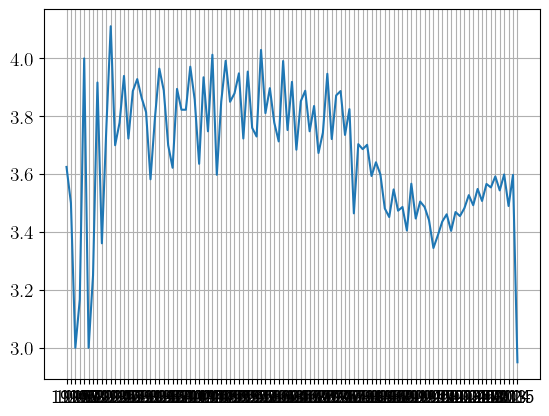

In [150]:
avg_ratings = question4.toPandas()
plt.plot(avg_ratings["year"], avg_ratings["avg(rating)"], label="avg(rating)")
plt.grid()
plt.show()

## Question 5: What are the top 3 genres per year ?

**hint** Look at the answer here https://stackoverflow.com/questions/38397796/retrieve-top-n-in-each-group-of-a-dataframe-in-pyspark

## Question 6: What words of the titles cooccure the most with each genre ? Is the number of cooccurence enough ? Compute the [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) between genres and movie title words, and filter out words that appear fewer than 100 times.